# Data Exploration and Feature Engineering

In [95]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sb
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor


pd.set_option('display.max_columns', None)  # To display all columns
pd.set_option('display.width', None)        # To avoid line wrapping
pd.set_option('display.max_rows', 100)

## Team Factor Feature

This proposed feature will theoretically help to account for how a players home field affects the number of homeruns a player may hit. Formula to calculate it will be:

$$ team factor = \frac{team score}{max(team score)} $$

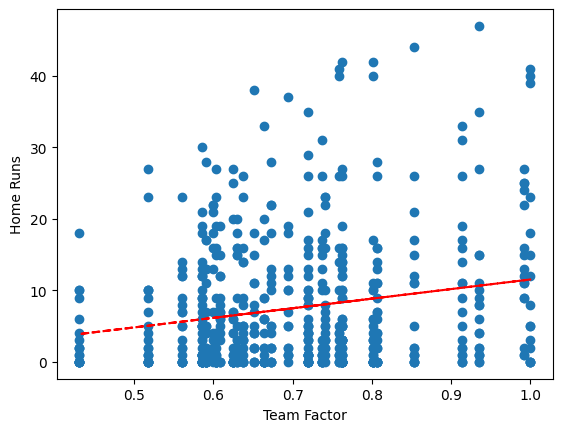

In [96]:
# Loading a 2015 team stats data set into a dataframe 
team_stats = pd.read_csv("../../data/raw/team_stats_2015.csv")

# adding a column for team factor feature
team_stats.insert(0, "tmFactor", 0)

# populating the team factor column for each team   
team_stats["tmFactor"] = team_stats["HR"]/max(team_stats["HR"])

# creating a dictionary of Team: team Factor
team_factor = team_stats.set_index("Team")["tmFactor"].to_dict()

# loading a season dataset and cleaning out some columns that are duplicates or
# appear to be blank on many rows based on a quick scan in excel
players =  pd.read_csv("../../data/raw/MLB_player_stats_2015.csv")
players = players[players['PA'] >= 20]
players = players.drop(columns=['Name.1', 'Team.1','UBR', 'wGDP', 'XBR'], axis=1)

# adding and populating team factor column on player stats data set
players.insert(0,  "tmFactor", 0)
players["tmFactor"] = players["Team"].map(team_factor)

# drop nan rows for team factor.
# These are caused by players that played for multiple teams in a season as their Team is listed as "- - -"

players = players.dropna(subset = ['tmFactor'])

# assigning columns to variables to for scatter plot and trendline
x = players["tmFactor"]
y = players["HR"]
z = np.polyfit(x, y, 1) # fits a linear polynomial
p = np.poly1d(z)    # creates a polynomial function from coefficients from z


plt.scatter(x,y)
plt.plot(x, p(x), "r--")
plt.xlabel("Team Factor")
plt.ylabel("Home Runs")
plt.show()

## Centering the team factor

A mean centered feature is "centered around the mean" by replacing the value with the value - mean value.  In ths case:

centered team factor = team factor - mean team factor 

or

$ x_i = x_i - \bar{x}$

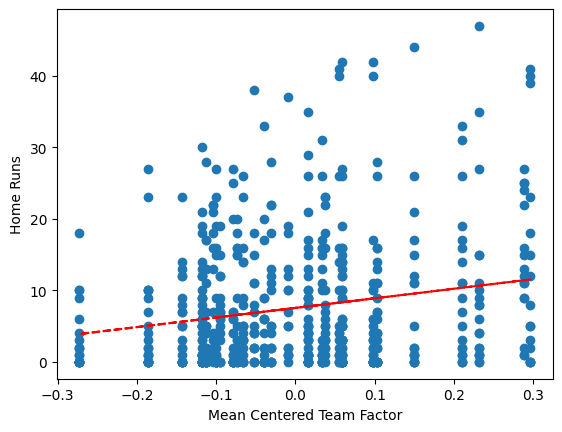

In [97]:
x_tm_factor_centered = players['tmFactor'] - players['tmFactor'].mean()

y = players["HR"]
z = np.polyfit(x_tm_factor_centered, y, 1) # fits a linear polynomial
p = np.poly1d(z)    # creates a polynomial function from coefficients from z


plt.scatter(x_tm_factor_centered,y)
plt.plot(x_tm_factor_centered, p(x_tm_factor_centered), "r--")
plt.xlabel("Mean Centered Team Factor")
plt.ylabel("Home Runs")
plt.show()

Text(0, 0.5, 'Home Runs')

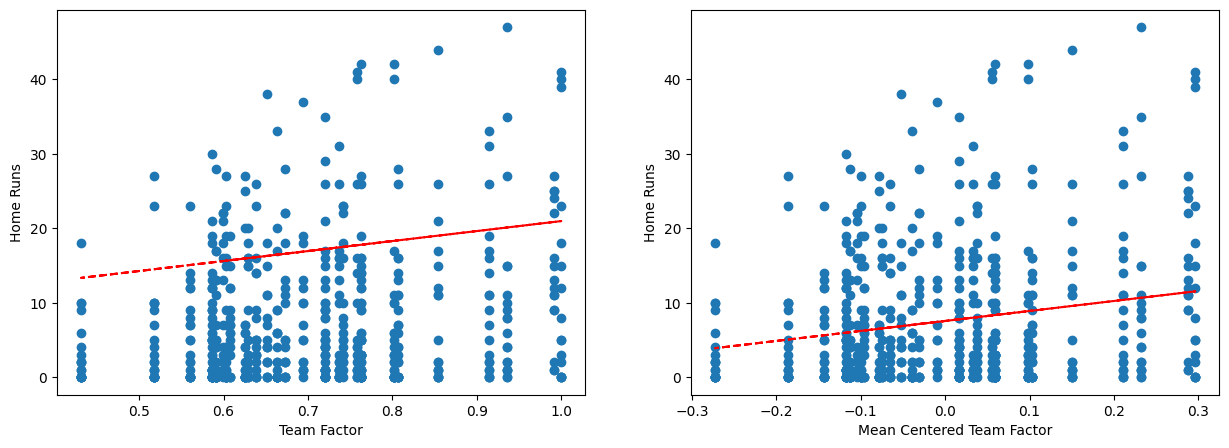

In [98]:
#from matplotlib.pyplot import subplots

fig, axes = plt.subplots(nrows=1,
                     ncols=2,
                     figsize=(15,5))

axes[1].scatter(x_tm_factor_centered,y)
axes[1].plot(x_tm_factor_centered, p(x_tm_factor_centered), "r--")
axes[1].set_xlabel("Mean Centered Team Factor")
axes[1].set_ylabel("Home Runs")

axes[0].scatter(x,y)
axes[0].plot(x, p(x), "r--")
axes[0].set_xlabel("Team Factor")
axes[0].set_ylabel("Home Runs")



mean centering does not change the shape of the data, but it does affect the location of the intercept of the plot line. This can help with colinearity and will be used for a second iteration of out linear regression model.

## Handling players who played for more than one team

$ Weighted team factor = \frac{\sum_i^n team_i Factor \times team_i PAs}{\sum_i^n team_i PA} $

This value will be calculated using the player stats with team splits and then inserted to the main data set.

## Player ages
Players ages will be scaled using the following formula:

$ \text{scaled player age} = \frac{\text{player age}}{50} $

## Season Factor
A scaled season factor will be used to account for changes to the game from season to season, such as the shortened 2020 season, balls started to be kept in humidors, or the introduction of the pitch clock.

This stat will be calculated much like the team factor stat

$ \text{Season factor} = \frac{season HRs}{max(season HRs)} $

The code snippet below if from the data processing script that shows how the season factor is generated and applied to the data set.


    # while looping through the datasets for each season
        # Create a new row in a DataFrame format to store the total number of homeruns for the sesaon
        new_row = pd.DataFrame({'season': [season], 'HR_total': [team_stats_df['HR'].sum()]})

        # Concatenate the new row with the existing DataFrame to store season total homeruns
        season_factor_df = pd.concat([season_factor_df, new_row], ignore_index=True)

        # Combine data into the main dataset
        combined_data_df = pd.concat([combined_data_df, player_stats_df], ignore_index=True)
    # end of loop

    # generate dictionary of season factors
    season_factor_df.insert(0, "season_factor", 0)
    season_factor_df['season_factor'] = season_factor_df['HR_total']/max(season_factor_df['HR_total'])
    season_factor_dict = season_factor_df.set_index('season')['season_factor'].to_dict()

    # Add season factor to the dataframe
    combined_data_df.insert(0, "season_factor", 0)
    combined_data_df["season_factor"] = combined_data_df["Season"].map(season_factor_dict)



## Selecting features for initial linear regression model
I will start by examining collinearity by generating a 

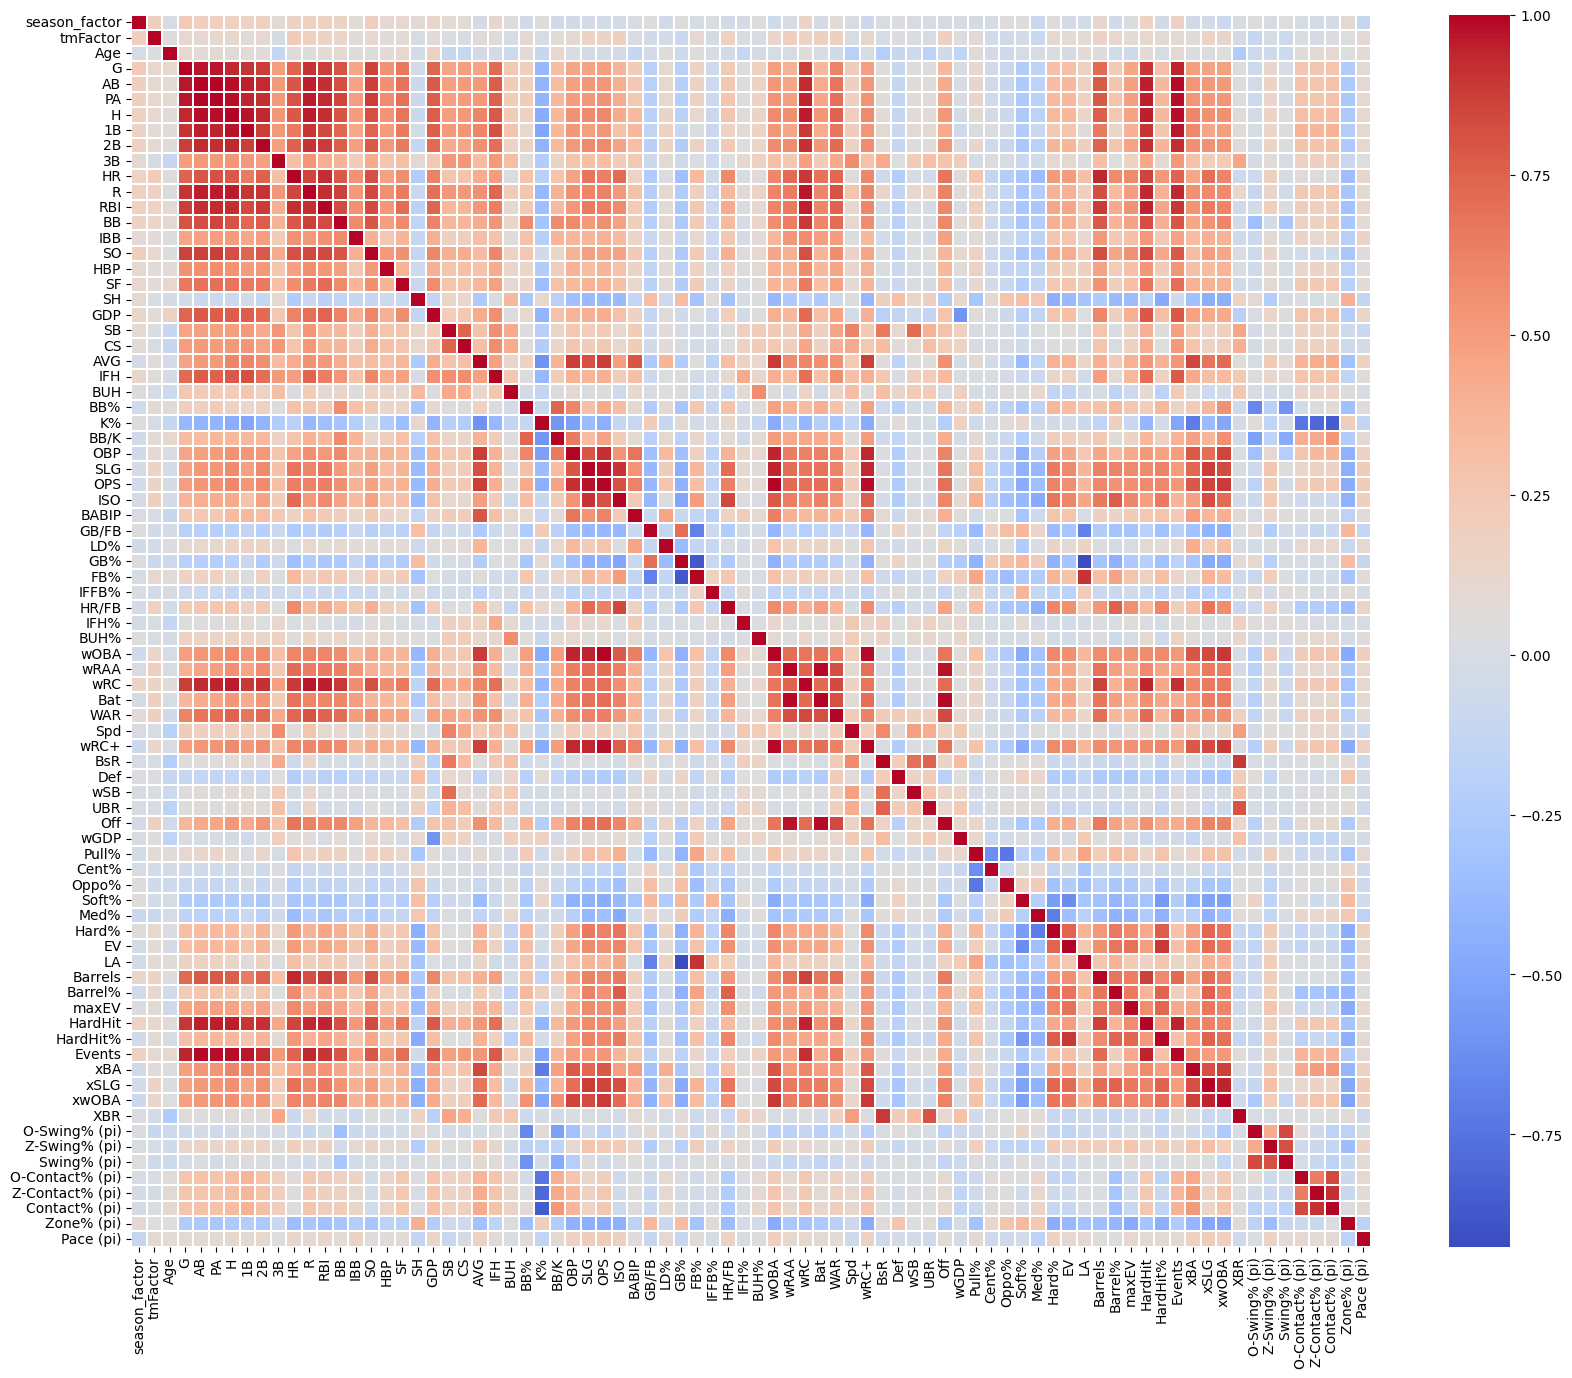

In [99]:
import seaborn as sns
players_df = pd.read_csv('../../data/processed/nicks_dataset.csv')

correlation_matrix = players_df.corr()
plt.figure(figsize=(20,16))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt='.2f', linewidths=0.1)
plt.show()



In [100]:
target = "HR"
target_corr = correlation_matrix[target].sort_values(ascending=False)

print("Feature Correlation with Target:")
print(target_corr.to_string())

Feature Correlation with Target:
HR                 1.000000
Barrels            0.934534
RBI                0.922273
wRC                0.887764
R                  0.854298
HardHit            0.851463
SO                 0.813661
PA                 0.807841
AB                 0.795820
H                  0.788086
BB                 0.787696
2B                 0.753524
Events             0.749049
G                  0.748750
WAR                0.733998
wRAA               0.716780
ISO                0.714881
xSLG               0.692900
Bat                0.691056
SLG                0.683475
Off                0.670916
1B                 0.660209
OPS                0.636889
GDP                0.618692
xwOBA              0.614521
wOBA               0.605976
wRC+               0.601529
HR/FB              0.589272
maxEV              0.587266
Barrel%            0.586302
SF                 0.571363
IBB                0.552869
HardHit%           0.520172
Hard%              0.517500
EV             

## Variance inflation factor

In [101]:
# Compute VIF for each feature
features = players_df.drop(columns=[target]).dropna()  # All columns except target

vif_data = pd.DataFrame()
vif_data["Feature"] = features.columns
vif_data["VIF"] = [variance_inflation_factor(features.values, i) for i in range(features.shape[1])]

print("Variance Inflation Factor (VIF):")
print(vif_data)

c:\Users\nick_\source\repos\BE2100_HR_predictions_ML_project\venv\lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Variance Inflation Factor (VIF):
            Feature           VIF
0     season_factor  1.575879e+00
1          tmFactor  1.258243e+00
2               Age  1.247074e+00
3                 G  1.899037e+01
4                AB  1.164060e+05
5                PA           inf
6                 H  2.039835e+04
7                1B  2.873683e+03
8                2B  1.659434e+02
9                3B  4.655268e+00
10                R  3.933468e+01
11              RBI  2.621158e+01
12               BB           inf
13              IBB  4.769362e+00
14               SO           inf
15              HBP           inf
16               SF  1.976987e+01
17               SH  8.572705e+00
18              GDP  1.708895e+01
19               SB  1.831301e+02
20               CS  6.969480e+01
21              AVG           inf
22              IFH  6.960070e+00
23              BUH  2.439635e+00
24              BB%  3.178660e+01
25               K%  2.834431e+01
26             BB/K  8.106813e+00
27             

### Interpreting VIF data can be done with the following criteria

| **VIF Value**       | **Interpretation**                                        |
|---------------------|-----------------------------------------------------------|
| **1**               | No correlation between the feature and other features.    |
| **1 < VIF < 5**     | Moderate correlation, but not problematic.                |
| **5 < VIF < 10**    | High correlation. This is a warning that multicollinearity might be an issue. |
| **VIF > 10**        | Very high correlation, indicating significant multicollinearity. This could cause issues with model stability and interpretation. |

Using these criteria, I will filter down feature lists for VIF values <=1, <5 and <10, and train a model with each set of features for comparison.

In [102]:
# Filter out features with VIF greater than 10
vif_threshold = 10

filtered_features = vif_data[vif_data["VIF"] < vif_threshold]["Feature"].tolist()

# Remove features with high VIF from X
players_filtered = players_df[filtered_features]

print(players_filtered)

      season_factor  tmFactor   Age  3B  IBB  SH  IFH  BUH      BB/K  \
0          0.724469  0.603448  0.76   0    0   9    0    0  0.000000   
1          0.724469  0.806034  0.68   0    1   3    1    0  0.842105   
2          0.724469  0.431034  0.76   1    2   0    7    0  0.513514   
3          0.724469  0.560345  0.48   4    0   1    3    0  0.390244   
4          0.724469  0.560345  0.74   0    0   9    2    0  0.055556   
...             ...       ...   ...  ..  ...  ..  ...  ...       ...   
5592       0.804752  0.801688  0.48   0    0   0    4    0  0.136364   
5593       0.804752  0.683544  0.58   5    0   0    3    0  0.347826   
5594       0.804752  0.696203  0.46   1    1   4    9    1  0.278571   
5595       0.804752  0.827004  0.48   2    0   3    8    1  0.202128   
5596       0.804752  0.888905  0.58   0    0   3    1    1  0.583333   

         GB/FB     IFFB%      IFH%      BUH%       Spd  UBR  wGDP         EV  \
0     5.000000  0.000000  0.000000  0.000000  0.142857 

This is interesting, when I originally explored the data, I worked with one season as the combined dataset had not been built yet. I also did not have the season factor incuded yet. This updated dataset produced a filtered list of features with 5 more features than when when I previously explored the data and practiced training a model. I can also see some of the columns have NaN values so I will check to see how prevelent they are.

In [103]:
# Count how many NaN values there are in each column
nan_counts = players_filtered.isna().sum()

# Print the result
print(nan_counts)

season_factor      0
tmFactor           9
Age                0
3B                 0
IBB                0
SH                 0
IFH                0
BUH                0
BB/K               0
GB/FB              0
IFFB%              0
IFH%               0
BUH%               0
Spd                0
UBR              356
wGDP             356
EV                 0
maxEV              0
Pace (pi)          0
dtype: int64


In [104]:
# Extract the column names from the dataframe
column_names = players_filtered.columns.tolist()

with open('../../data/lr_model1_feature_list.txt', 'w') as f:
    for column in column_names:
        f.write(column + '\n')


In [105]:
vif_threshold = 5

filtered_features = vif_data[vif_data["VIF"] < vif_threshold]["Feature"].tolist()

# Remove features with high VIF from X
players_filtered = players_df[filtered_features]

print(players_filtered)

      season_factor  tmFactor   Age  3B  IBB  BUH     IFFB%      IFH%  \
0          0.724469  0.603448  0.76   0    0    0  0.000000  0.000000   
1          0.724469  0.806034  0.68   0    1    0  0.020000  0.016129   
2          0.724469  0.431034  0.76   1    2    0  0.121495  0.040230   
3          0.724469  0.560345  0.48   4    0    0  0.108108  0.076923   
4          0.724469  0.560345  0.74   0    0    0  0.000000  0.095238   
...             ...       ...   ...  ..  ...  ...       ...       ...   
5592       0.804752  0.801688  0.48   0    0    0  0.142857  0.210526   
5593       0.804752  0.683544  0.58   5    0    0  0.041237  0.040000   
5594       0.804752  0.696203  0.46   1    1    1  0.090909  0.051136   
5595       0.804752  0.827004  0.48   2    0    1  0.110169  0.060606   
5596       0.804752  0.888905  0.58   0    0    1  0.083333  0.071429   

          BUH%       Spd  UBR    maxEV  Pace (pi)  
0     0.000000  0.142857  NaN  104.322  22.119048  
1     0.000000  1.0

This new list filtered to VIF values < 5 is a little

In [106]:
# Count how many NaN values there are in each column
nan_counts = players_filtered.isna().sum()

# Print the result
print(nan_counts)

season_factor      0
tmFactor           9
Age                0
3B                 0
IBB                0
BUH                0
IFFB%              0
IFH%               0
BUH%               0
Spd                0
UBR              356
maxEV              0
Pace (pi)          0
dtype: int64


In [107]:
# Extract the column names from the dataframe
column_names = players_filtered.columns.tolist()

with open('../../data/lr_model2_feature_list.txt', 'w') as f:
    for column in column_names:
        f.write(column + '\n')

In [108]:
vif_threshold = 1

filtered_features = vif_data[vif_data["VIF"] <= vif_threshold]["Feature"].tolist()

# Remove features with high VIF from X
players_filtered = players_df[filtered_features]

print(players_filtered)

Empty DataFrame
Columns: []
Index: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, ...]

[5597 rows x 0 columns]
